<a href="https://colab.research.google.com/github/Joshua250304/soccer-predictor-2025-26-season/blob/main/prediction_2025_26_season.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"joshuakidron","key":"36243d4c445fa6a337ded33b332b4dd0"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv 'kaggle (2).json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d flynn28/2025-premier-league-stats-matches-salaries

Dataset URL: https://www.kaggle.com/datasets/flynn28/2025-premier-league-stats-matches-salaries
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/57.8k [00:00<?, ?B/s]
100% 57.8k/57.8k [00:00<00:00, 211MB/s]


In [4]:
!unzip 2025-premier-league-stats-matches-salaries.zip

Archive:  2025-premier-league-stats-matches-salaries.zip
  inflating: fixtures.csv            
  inflating: player_possession_stats.csv  
  inflating: player_salaries.csv     
  inflating: player_stats.csv        
  inflating: standings.csv           
  inflating: team_possession_stats.csv  
  inflating: team_salary.csv         
  inflating: team_stats.csv          


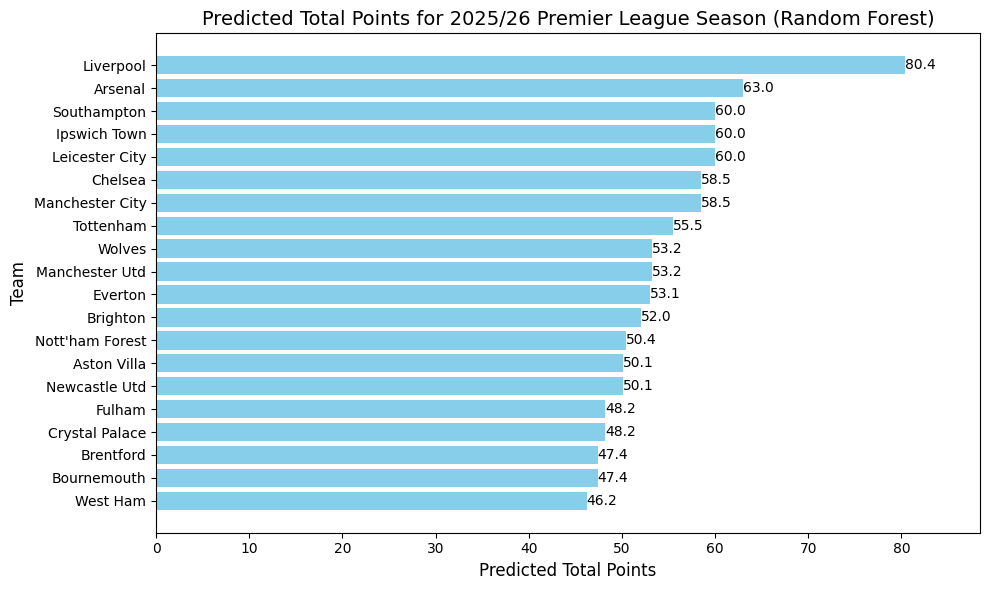

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Load the data
github_csv_url = 'https://raw.githubusercontent.com/footballcsv/cache.footballdata/refs/heads/master/2023-24/eng.1.csv'
df_eng1 = pd.read_csv(github_csv_url)
df_fixtures = pd.read_csv('fixtures.csv')

# Define mapping for inconsistent team names
mapping = {
    'Man City': 'Manchester City',
    'Man United': 'Manchester Utd',
    'Nott\'m Forest': 'Nott\'ham Forest',
}

def clean_team_name(team):
    return mapping.get(team, team)

# Function to calculate match points
def calculate_points(row, team_col, home_goals_col, away_goals_col):
    if row[home_goals_col] > row[away_goals_col]:
        return 3 if row[team_col] == row['Home'] else 0
    elif row[home_goals_col] < row[away_goals_col]:
        return 0 if row[team_col] == row['Home'] else 3
    else:
        return 1

# --- 1. Data Preparation: 2023/24 Season Stats ---

# Calculate 2023/24 stats (PPG_23_24)
df_23_24 = df_eng1.copy()
df_23_24[['HomeGoals', 'AwayGoals']] = df_23_24['FT'].str.split('-', expand=True).astype(int)
df_23_24.rename(columns={'Team 1': 'Home', 'Team 2': 'Away'}, inplace=True)

df_home_23_24 = df_23_24[['Home', 'Away', 'HomeGoals', 'AwayGoals']].copy()
df_home_23_24['Points'] = df_home_23_24.apply(lambda row: calculate_points(row, 'Home', 'HomeGoals', 'AwayGoals'), axis=1)
df_away_23_24 = df_23_24[['Home', 'Away', 'HomeGoals', 'AwayGoals']].copy()
df_away_23_24['Points'] = df_away_23_24.apply(lambda row: calculate_points(row, 'Away', 'HomeGoals', 'AwayGoals'), axis=1)

team_stats_23_24 = pd.concat([
    df_home_23_24.rename(columns={'Home': 'Team'}),
    df_away_23_24.rename(columns={'Away': 'Team'})
]).groupby('Team').agg(
    TotalPoints_23_24=('Points', 'sum'),
    GamesPlayed_23_24=('Points', 'count')
).reset_index()

team_stats_23_24['PPG_23_24'] = team_stats_23_24['TotalPoints_23_24'] / team_stats_23_24['GamesPlayed_23_24']


# --- 2. Data Preparation: 2024/25 Season Stats ---

# Calculate 2024/25 stats (TotalPoints_24_25 and PPG_24_25)
df_24_25 = df_fixtures.copy()
df_24_25['HomeScore'] = pd.to_numeric(df_24_25['HomeScore'], errors='coerce').astype('Int64')
df_24_25['AwayScore'] = pd.to_numeric(df_24_25['AwayScore'], errors='coerce').astype('Int64')
df_24_25.dropna(subset=['HomeScore', 'AwayScore'], inplace=True)
df_24_25['HomeScore'] = df_24_25['HomeScore'].astype(int)
df_24_25['AwayScore'] = df_24_25['AwayScore'].astype(int)

df_home_24_25 = df_24_25[['Home', 'Away', 'HomeScore', 'AwayScore']].copy()
df_home_24_25['Points'] = df_home_24_25.apply(lambda row: calculate_points(row, 'Home', 'HomeScore', 'AwayScore'), axis=1)
df_away_24_25 = df_24_25[['Home', 'Away', 'HomeScore', 'AwayScore']].copy()
df_away_24_25['Points'] = df_away_24_25.apply(lambda row: calculate_points(row, 'Away', 'HomeScore', 'AwayScore'), axis=1)

team_stats_24_25 = pd.concat([
    df_home_24_25.rename(columns={'Home': 'Team'}),
    df_away_24_25.rename(columns={'Away': 'Team'})
]).groupby('Team').agg(
    TotalPoints_24_25=('Points', 'sum'),
    GamesPlayed_24_25=('Points', 'count')
).reset_index()

team_stats_24_25['PPG_24_25'] = team_stats_24_25['TotalPoints_24_25'] / team_stats_24_25['GamesPlayed_24_25']


# --- 3. Prepare Training and Prediction DataFrames ---
team_stats_23_24['Team'] = team_stats_23_24['Team'].apply(clean_team_name)
team_stats_24_25['Team'] = team_stats_24_25['Team'].apply(clean_team_name)

team_stats_23_24_clean = team_stats_23_24.groupby('Team').sum().reset_index()
team_stats_24_25_clean = team_stats_24_25.groupby('Team').sum().reset_index()

df_merged = pd.merge(
    team_stats_23_24_clean[['Team', 'PPG_23_24']],
    team_stats_24_25_clean[['Team', 'PPG_24_25', 'TotalPoints_24_25', 'GamesPlayed_24_25']],
    on='Team',
    how='outer'
)

# Training Data (2023/24 PPG -> 2024/25 Total Points)
df_train = df_merged.dropna(subset=['PPG_23_24', 'TotalPoints_24_25']).copy()

# Prediction Data (2024/25 PPG -> 2025/26 Total Points)
df_predict = df_merged[df_merged['GamesPlayed_24_25'] == 38].copy()
df_predict.rename(columns={'PPG_24_25': 'PPG_23_24_for_prediction'}, inplace=True)


# --- 4. Random Forest Model Training ---
X_train = df_train[['PPG_23_24']]
y_train = df_train['TotalPoints_24_25']

model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)


# --- 5. Prediction for 2025/26 Season ---
X_predict = df_predict[['PPG_23_24_for_prediction']].rename(columns={'PPG_23_24_for_prediction': 'PPG_23_24'})

# Predict 2025/26 Total Points
df_predict.loc[X_predict.index, 'Predicted_TotalPoints_25_26'] = model.predict(X_predict)

# 6. Final Prediction DataFrame
df_prediction_rf = df_predict[['Team', 'Predicted_TotalPoints_25_26']].sort_values(
    by='Predicted_TotalPoints_25_26', ascending=False
).reset_index(drop=True)

# --- 7. Data Visualization ---

# Sort data for plotting (lowest to highest for a clean horizontal bar chart)
df_plot = df_prediction_rf.sort_values(by='Predicted_TotalPoints_25_26', ascending=True)

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df_plot['Team'], df_plot['Predicted_TotalPoints_25_26'], color='skyblue')

# Add titles and labels
plt.title('Predicted Total Points for 2025/26 Premier League Season (Random Forest)', fontsize=14)
plt.xlabel('Predicted Total Points', fontsize=12)
plt.ylabel('Team', fontsize=12)

# Add data labels on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.1f}',
             va='center', ha='left')

# Adjust plot aesthetics
plt.xlim(0, df_plot['Predicted_TotalPoints_25_26'].max() * 1.1) # Extend x-limit for labels
plt.tight_layout()
plt.savefig('2025_26_predicted_points_comparison.png')
plt.show()